# Modelos sin los fetures de sentimiento

In [1]:
import pandas as pd

# Reemplazá el nombre del archivo por la ruta correcta si no está en el mismo directorio
analisis_df = pd.read_csv("data_set_integrado_modelo_final_futuro_binario.csv")

# Ver features
print(analisis_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_cotizacion                              2909 non-null   int64  
 1   id_empresa                                 2909 non-null   int64  
 2   fecha                                      2909 non-null   object 
 3   precio_apertura                            2909 non-null   float64
 4   precio_cierre                              2909 non-null   float64
 5   precio_max                                 2909 non-null   float64
 6   precio_min                                 2909 non-null   float64
 7   volumen_operado                            2909 non-null   float64
 8   variacion_porcentaje                       2862 non-null   float64
 9   nombre                                     2909 non-null   object 
 10  label                   

## Eliminamos los features que tienen que ver con sentimientos y noticias

In [3]:
# Palabras clave para excluir columnas relacionadas con noticias o sentimientos
excluir_keywords = [
    'noticias', 'sentimiento', 'score', 'valoracion_llm',
    'ratio_sent', 'diff_score'
]

# Filtrar columnas
columnas_a_eliminar = [col for col in analisis_df.columns if any(k in col for k in excluir_keywords)]

# Crear nuevo DataFrame sin esas columnas
analisis_sin_noticias_df = analisis_df.drop(columns=columnas_a_eliminar)

# Verificar resultado
print(f"Columnas eliminadas: {len(columnas_a_eliminar)}")
print(f"Nuevo shape: {analisis_sin_noticias_df.shape}")

print(analisis_sin_noticias_df.info())


Columnas eliminadas: 35
Nuevo shape: (2909, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id_cotizacion                  2909 non-null   int64  
 1   id_empresa                     2909 non-null   int64  
 2   fecha                          2909 non-null   object 
 3   precio_apertura                2909 non-null   float64
 4   precio_cierre                  2909 non-null   float64
 5   precio_max                     2909 non-null   float64
 6   precio_min                     2909 non-null   float64
 7   volumen_operado                2909 non-null   float64
 8   variacion_porcentaje           2862 non-null   float64
 9   nombre                         2909 non-null   object 
 10  label                          2909 non-null   object 
 11  variacion_total_cotizacion     2909 non-null   float64
 12  

# Aplicamos PCA

## Paso 1: Preprocesamiento

- Excluir columnas no numéricas (objetivo, fechas, textos)
- Escalar los datos (requisito para PCA)

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Copia del dataset original sin columnas categóricas ni target
pca_df = analisis_sin_noticias_df.copy()

# Separar variable objetivo
y = pca_df['label_t_plus_1']

# Eliminar columnas no numéricas
cols_a_excluir = ['label_t_plus_1', 'label', 'nombre', 'fecha', 'fecha_publicacion']
pca_features = pca_df.drop(columns=cols_a_excluir)

# Asegurarse de no tener valores nulos
pca_features = pca_features.dropna()

# Escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_features)


## Paso 2: Aplicar PCA

In [5]:
# Aplicamos PCA para 2 componentes (visualización)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear dataframe con componentes y clase
import pandas as pd
pca_result = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_result['label'] = y.iloc[pca_features.index].values


## Paso 3: Visualización

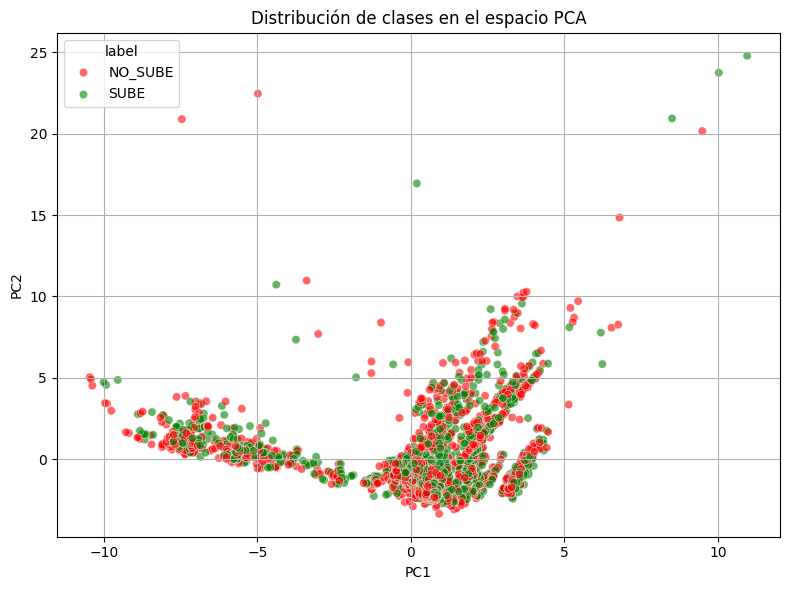

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='label',
    data=pca_result,
    palette={'SUBE': 'green', 'NO_SUBE': 'red'},
    alpha=0.6
)
plt.title("Distribución de clases en el espacio PCA")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.2663208  0.16237138]


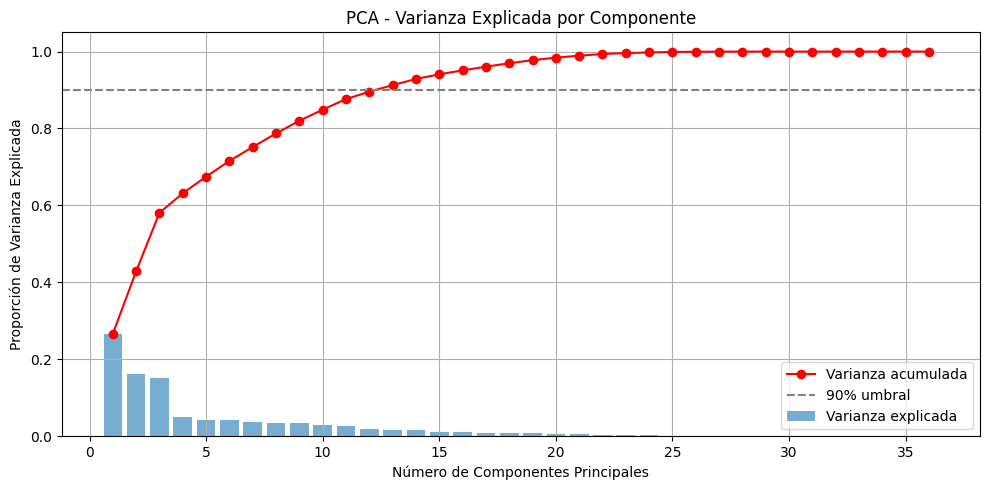

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA con todos los componentes posibles
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza explicada individual y acumulada
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Graficar
plt.figure(figsize=(10, 5))

# Gráfico de barras: varianza explicada por componente
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza explicada')

# Gráfico de línea: varianza acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Varianza acumulada')

plt.axhline(0.90, color='gray', linestyle='--', label='90% umbral')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('PCA - Varianza Explicada por Componente')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# PCA Aplicada

## Paso 1: Determinar cuántas componentes retener

In [9]:
# Calcular cuántas componentes explican al menos el 90% de la varianza
n_componentes_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"🔢 Número de componentes necesarias para explicar el 90% de la varianza: {n_componentes_90}")


🔢 Número de componentes necesarias para explicar el 90% de la varianza: 13


## Paso 2: Aplicar PCA reducida y crear nuevo dataset

In [11]:
# PCA con número óptimo de componentes
pca_reducido = PCA(n_components=n_componentes_90)
X_pca_reducido = pca_reducido.fit_transform(X_scaled)

# Crear DataFrame con las componentes retenidas + target
pca_reduced_df = pd.DataFrame(X_pca_reducido, columns=[f'PC{i+1}' for i in range(n_componentes_90)])
pca_reduced_df['label_t_plus_1'] = y.iloc[pca_features.index].values

# Verificar
print(f"✅ Dataset reducido: {pca_reduced_df.shape}")

print(pca_reduced_df.info())


✅ Dataset reducido: (2826, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PC1             2826 non-null   float64
 1   PC2             2826 non-null   float64
 2   PC3             2826 non-null   float64
 3   PC4             2826 non-null   float64
 4   PC5             2826 non-null   float64
 5   PC6             2826 non-null   float64
 6   PC7             2826 non-null   float64
 7   PC8             2826 non-null   float64
 8   PC9             2826 non-null   float64
 9   PC10            2826 non-null   float64
 10  PC11            2826 non-null   float64
 11  PC12            2826 non-null   float64
 12  PC13            2826 non-null   float64
 13  label_t_plus_1  2826 non-null   object 
dtypes: float64(13), object(1)
memory usage: 309.2+ KB
None


# Flujo de entrenamiento con pca_reduced_df
## Paso 1: Preprocesar datos para modelado

In [12]:
from autogluon.tabular import TabularPredictor

# Copia limpia
df_model = pca_reduced_df.copy()

# Dividir en train y test (80/20) manteniendo el orden temporal
df_model = df_model.sort_index()  # mantiene alineación con fechas si fuera relevante
train_size = int(len(df_model) * 0.8)

train_df = df_model.iloc[:train_size].copy()
test_df = df_model.iloc[train_size:].copy()


## Paso 2: Entrenar con AutoGluon

In [13]:
predictor_pca = TabularPredictor(
    label='label_t_plus_1',
    problem_type='binary'
).fit(
    train_data=train_df,
    verbosity=2
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250503_020425"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          14
Memory Avail:       1.16 GB / 15.31 GB (7.6%)
Disk Space Avail:   284.83 GB / 475.95 GB (59.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'        

## Paso 3: Evaluar desempeño

📊 Reporte de clasificación (modelo PCA):
              precision    recall  f1-score   support

     NO_SUBE       0.55      0.56      0.56       310
        SUBE       0.46      0.45      0.45       256

    accuracy                           0.51       566
   macro avg       0.51      0.51      0.51       566
weighted avg       0.51      0.51      0.51       566



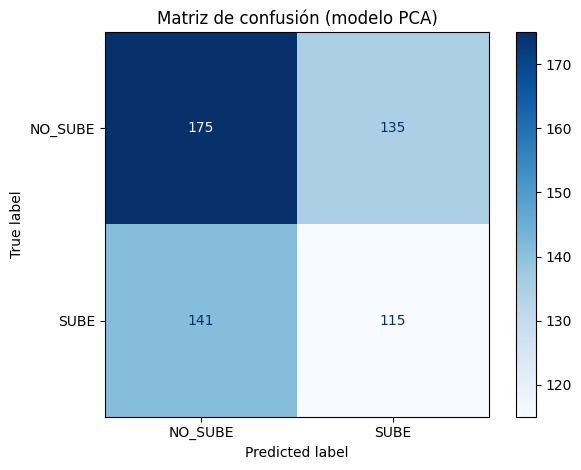

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predicción y métricas
y_true = test_df['label_t_plus_1']
y_pred = predictor_pca.predict(test_df.drop(columns='label_t_plus_1'))

print("📊 Reporte de clasificación (modelo PCA):")
print(classification_report(y_true, y_pred, target_names=['NO_SUBE', 'SUBE']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO_SUBE', 'SUBE'])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión (modelo PCA)")
plt.grid(False)
plt.tight_layout()
plt.show()


# Entrenamiento de dataset sin sentimnientos y noticias

## Objetivo, separar los datos en:

- train → entrenamiento del modelo
- val → validación (opcional si no hacés cross-validation)
- test → evaluación final, sin filtrar aleatoriamente, sino respetando el orden temporal

### Paso 1: Preparar los datos
- Asegurar tipos y ordenar cronológicamente

In [17]:
# Asegurar que 'fecha' sea datetime
analisis_sin_noticias_df['fecha'] = pd.to_datetime(analisis_sin_noticias_df['fecha'])

# Ordenar por fecha (temporalmente coherente)
analisis_sin_noticias_df = analisis_sin_noticias_df.sort_values(by='fecha').reset_index(drop=True)


### Paso 2: Definir conjunto de entrenamiento y test (ej. 80/20)

In [18]:
# Tamaño total
n_total = len(analisis_sin_noticias_df)

# Dividir 80% train, 20% test (o ajustá como necesites)
train_size = int(n_total * 0.8)

# Separar
train_df = analisis_sin_noticias_df.iloc[:train_size].copy()
test_df  = analisis_sin_noticias_df.iloc[train_size:].copy()



### Paso 3: Revisar variable objetivo

In [19]:
print(train_df['label_t_plus_1'].value_counts(normalize=True))
print(test_df['label_t_plus_1'].value_counts(normalize=True))


label_t_plus_1
NO_SUBE    0.52514
SUBE       0.47486
Name: proportion, dtype: float64
label_t_plus_1
NO_SUBE    0.603093
SUBE       0.396907
Name: proportion, dtype: float64


## Entrenar un modelo con AutoGluon sobre el dataset completo (analisis_sin_noticias_df)
### Paso 1: Definir los features y entrenar el modelo

In [20]:
from autogluon.tabular import TabularPredictor

# Lista de columnas a excluir (objetivo y no predictivas)
excluded_cols = ['label', 'label_t_plus_1', 'nombre', 'fecha', 'fecha_publicacion']

# Seleccionar columnas predictoras automáticamente
feature_cols = [col for col in train_df.columns if col not in excluded_cols]

# Entrenamiento
predictor_sin_noticias = TabularPredictor(
    label='label_t_plus_1',
    problem_type='binary'
).fit(
    train_data=train_df[feature_cols + ['label_t_plus_1']],
    verbosity=2
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250503_022814"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          14
Memory Avail:       1.21 GB / 15.31 GB (7.9%)
Disk Space Avail:   284.21 GB / 475.95 GB (59.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'        

### Paso 2: Evaluar desempeño sobre el test set

📊 Reporte de clasificación (modelo sin noticias):
              precision    recall  f1-score   support

     NO_SUBE       0.64      0.55      0.59       351
        SUBE       0.44      0.53      0.48       231

    accuracy                           0.54       582
   macro avg       0.54      0.54      0.54       582
weighted avg       0.56      0.54      0.55       582



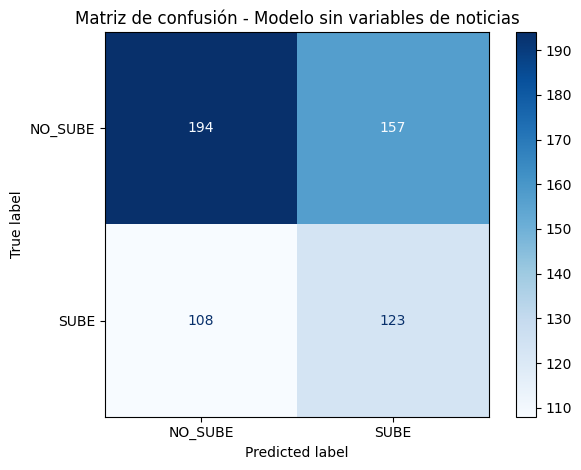

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Variables reales y predichas
y_true = test_df['label_t_plus_1']
y_pred = predictor_sin_noticias.predict(test_df[feature_cols])

# Métricas
print("📊 Reporte de clasificación (modelo sin noticias):")
print(classification_report(y_true, y_pred, target_names=['NO_SUBE', 'SUBE']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO_SUBE', 'SUBE'])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión - Modelo sin variables de noticias")
plt.grid(False)
plt.tight_layout()
plt.show()


### Paso 3 (opcional): Ver feature importance

These features in provided data are not utilized by the predictor and will be ignored: ['fecha', 'nombre', 'label', 'fecha_publicacion']
Computing feature importance via permutation shuffling for 36 features using 582 rows with 5 shuffle sets...
	8.98s	= Expected runtime (1.8s per shuffle set)
	1.52s	= Actual runtime (Completed 5 of 5 shuffle sets)
C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_23296\2804223242.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15).reset_index(), x='importance', y='index', palette='viridis')


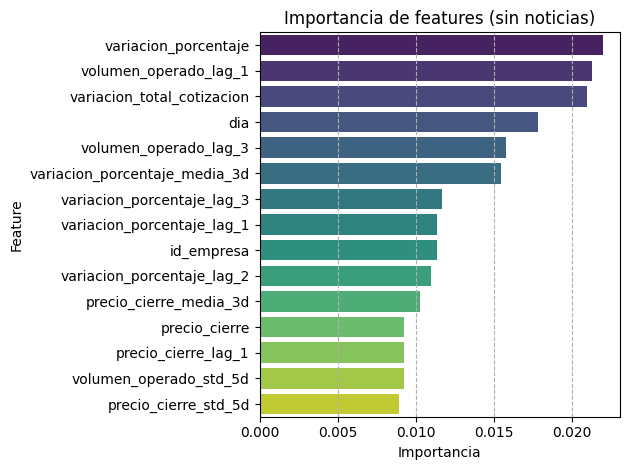

In [22]:
import seaborn as sns
importance_df = predictor_sin_noticias.feature_importance(test_df)

# Mostrar top 15
sns.barplot(data=importance_df.head(15).reset_index(), x='importance', y='index', palette='viridis')
plt.title('Importancia de features (sin noticias)')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--')
plt.tight_layout()
plt.show()
